# Lab 4
## More Data Scraping and EDA

In this lab, you will improve your skills in scraping data from web pages, organizing the data in a desired format, and performing EDA.

For this lab, we are reusing code from Harvard's CS109: https://github.com/cs109/2015/blob/master/Lectures/02-DataScrapingQuizzes.ipynb

## Lab3.A. Run code for scraping Indeed.com data

You firs task will be to exectute the following blocks of code and try to understand what is happening after each line of the code. You will have to answer several questions to show your understanding.

Let us start with importing of the relevant packages.

In [1]:
import urllib2
import bs4 #this is beautiful soup

import time
from pandas import Series
import pandas as pd
from pandas import DataFrame
import numpy as np
import socket
import re
import requests
import json

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

As you see, you imported the package called `re`, which supports regular expression operations. You have already used the other packages. 

The following block will access and load the contents of an Indeed.com web page. It will probably give you a warning -- please ignore it.

In [2]:
# Fixed url for job postings containing data scientist
url = 'http://www.indeed.com/jobs?q=data+scientist&l='
# read the website
source = urllib2.urlopen(url).read()
# parse html code
bs_tree = bs4.BeautifulSoup(source)

C:\Users\Hoang\Anaconda2\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file C:\Users\Hoang\Anaconda2\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


** Question 1**:
 * What kind of page did you land on? Explain in a few sentences what is the content of this page.
 * What does the "?" and "&" in the url mean?
 * Explore the content of the web page. If you are using Firefox, open the page Inspector to understand how the underlying html code relates to the displayed content.
 * What pieces of the html code are responsible for showing the job title, company name, and job location?
 
The following block of code will figure out how many job ads are there for jobs that contain "data scientist' in the job title.

#Question 1

The page display the search on keyword "data science" on indeed.com. There are around 13 results each page. There is an ad on the right hand side, and there are some sorting values on the left hand side. 

Meaning of url: An optional query, separated from the preceding part by a question mark (?), containing a query string of non-hierarchical data. The & is how you string together additional information.

q is responsible for job title/company and l is responsible for job location

In [3]:
# see how many job postings we found
job_count_string = bs_tree.find(id = 'searchCount').contents[0]
job_count_string = job_count_string.split()[-2]
print("Search yielded %s hits." % (job_count_string))

# not that job_count so far is still a string, 
# not an integer, and the , separator prevents 
# us from just casting it to int

job_count_digits = [int(d) for d in job_count_string if d.isdigit()]
job_count = np.sum([digit*(10**exponent) for digit, exponent in 
                    zip(job_count_digits[::-1], range(len(job_count_digits)))])

print job_count

Search yielded 24,685 hits.
24685


** Question 2**:
* What does the "find(id = 'searchCount')" in the first line mean?
* What does the second line do?

**Question 3**: 
* Write a piece of code that finds the Salary Estimate object on the page

The following piece of code allows you to find the links to all the job ads on the page.

#Question 2

find(id = 'searchCount') means find the first value with the id = 'searchCount'. The second line split the string value into a list using white space as separator, and then it take the second to last element of the list: this is the string that display the number of jobs searched


In [4]:
#question 3
bs_tree.find(id = 'rb_Salary Estimate')

<div class="rbSection rbOpen" id="rb_Salary Estimate">\n<div class="rbHeader">\n<span aria-level="3" class="ws_bold" role="heading">\n                    Salary Estimate</span>\n</div>\n<div class="rbsrbo" id="SALARY_rbo">\n<ul class="rbList">\n<li onmousedown="rbptk('rb', 'salest', '1');">\n<a href="/q-data-scientist-$55,000-jobs.html" rel="nofollow" title="$55,000 (19940)">$55,000</a> (19940)</li>\n<li onmousedown="rbptk('rb', 'salest', '2');">\n<a href="/q-data-scientist-$75,000-jobs.html" rel="nofollow" title="$75,000 (15863)">$75,000</a> (15863)</li>\n<li onmousedown="rbptk('rb', 'salest', '3');">\n<a href="/q-data-scientist-$95,000-jobs.html" rel="nofollow" title="$95,000 (11636)">$95,000</a> (11636)</li>\n<li onmousedown="rbptk('rb', 'salest', '4');">\n<a href="/q-data-scientist-$110,000-jobs.html" rel="nofollow" title="$110,000 (8179)">$110,000</a> (8179)</li>\n<li onmousedown="rbptk('rb', 'salest', '5');">\n<a href="/q-data-scientist-$130,000-jobs.html" rel="nofollow" title="$

In [5]:
# The website is only listing 10 results per page, 
# so we need to scrape them page after page
num_pages = int(np.ceil(job_count/10.0))

base_url = 'http://www.indeed.com'
job_links = []
for i in range(1): #do range(num_pages) if you want them all
    url = 'http://www.indeed.com/jobs?q=data+scientist&start=' + str(i*10)
    html_page = urllib2.urlopen(url).read() 
    bs_tree = bs4.BeautifulSoup(html_page)
    job_link_area = bs_tree.find(id = 'resultsCol')
    job_postings = job_link_area.findAll("div")
    job_postings = [jp for jp in job_postings if not jp.get('class') is None 
                    and ''.join(jp.get('class')) =="rowresult"]
    job_ids = [jp.get('data-jk') for jp in job_postings]
    
    # go after each link
    for id in job_ids:
        job_links.append(base_url + '/rc/clk?jk=' + id)
    
    time.sleep(1)

print "We found a lot of jobs: ", len(job_links)

We found a lot of jobs:  13


**Question 4**:
* explain why is `url` (first line in the for loop) defined as it is. What page are you landing at when `i = 3`?
* What does command `bs_tree.find(id = 'resultsCol')` do?
* What does command `''.join(jp.get('class'))` do?
* Explain the properties and content of `job_links`

**Question 5**:
* Reuse the code above to find links to the first 200 listed data science jobs

The following piece of code accesses and grabs the content of all ads in the `job_links` and extracts all the human-readable text tokens. Then, it counts on how many pages are words `mapreduce`, `spark`, and `visualization` used. It might take a few seconds to execute.

#Question 4

the url in the first line is the original url of indeed.com. We want to store the origin url so that we can append further information and querry into the original url to reach the page we want. When i = 3, we will be on page 4. 

the command bs_tree.find(id = 'resultsCol') find the first value with the id 'resultsCol'

job_postings is a list of strings that contain div tag. For each jp in job_postings, we get the class of that block, which will return a list of string(s), and we use ''.join(jp.get('class')) to join all the string(s) inside. 

job_links is a list that contains strings of urls of each job posting that we see in the page we scrape. 



In [6]:
#question 5
num_pages = int(np.ceil(job_count/10.0))

base_url = 'http://www.indeed.com'
job_links = []

for i in range(17): #since we want 200 jobs, we need to scrape 17 pages
    url = 'http://www.indeed.com/jobs?q=data+scientist&start=' + str(i*10)
    html_page = requests.get(url)
    bs_tree = bs4.BeautifulSoup(html_page.text, 'html.parser')
    job_link_area = bs_tree.find(id = 'resultsCol')
    job_postings = job_link_area.findAll('div')
    job_postings = [jp for jp in job_postings if jp.get('class') and ''.join(jp.get('class')) == 'rowresult']
    job_ids = [jp.get('data-jk') for jp in job_postings]
    
    for i in job_ids:
        job_links.append(base_url + '/rc/clk?jk=' + i)
    
    time.sleep(1)        
job_links = job_links[:200]
print "We found a lot of jobs: ", len(job_links)

We found a lot of jobs:  200


In [7]:
skill_set = {'mapreduce':0, 'spark':0, 'visualization':0}
counter = 0
for link in job_links:
    counter +=1  
    
    try:
        html_page = urllib2.urlopen(link).read()
    except urllib2.HTTPError:
        print "HTTPError:"
        continue
    except urllib2.URLError:
        print "URLError:"
        continue
    except socket.error as error:
        print "Connection closed"
        continue

    html_text = re.sub("[^a-z.+3]"," ", html_page.lower()) # replace all but the listed characters
        
    for key in skill_set.keys():
        if key in html_text:  
            skill_set[key] +=1
            
#     if counter % 5 == 0:
#         print len(job_links) - counter
#         print skill_set
            
print skill_set

HTTPError:
URLError:
URLError:
URLError:
HTTPError:
URLError:
URLError:
HTTPError:
URLError:
URLError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
URLError:
HTTPError:
URLError:
URLError:
URLError:
HTTPError:
HTTPError:
URLError:
HTTPError:
URLError:
HTTPError:
URLError:
HTTPError:
HTTPError:
URLError:
URLError:
URLError:
HTTPError:
HTTPError:
HTTPError:
HTTPError:
URLError:
HTTPError:
HTTPError:
HTTPError:
{'visualization': 36, 'spark': 51, 'mapreduce': 3}


** Question 6**
* What does the `re.sub()` do in the above code? To answer this, you will have to go to the documentation of the regular expression package (find it on web).
* What is the meaning of `[^a-z.+3]`?
* What is the content of `skill_set`?

The following piece of code plots the counts of different skills in the processed ads.

re.sub(pattern,repl,string): will return the string obtained by replacing the leftmost non-overlapping occurences of the pattern in string by the replacement repl. If the pattern isn't found, the string is returned unchanged. 

[^a-z.+3] means "match from the start of the string, all lowercase characters, except the newline; +3 allows for up to 3 repetitions of the preceding. In the code above, re.sub replace everything in the html_page except this pattern by a whitespace. To be clearer, re.sub replace all non-characters in the html_page with whitespace and only keeps lowercase character.  

skill_set is a dictionary with the skills we want to look for as keys and the number of appearance of each of them as value

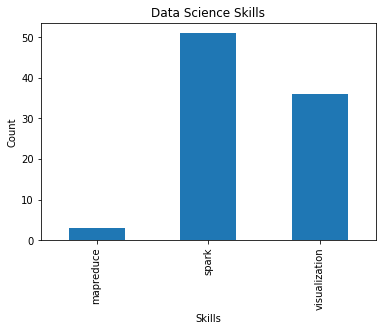

In [10]:
pseries = pd.Series(skill_set)
pseries.sort_values(ascending=True)

pseries.plot(kind = 'bar')
## set the title to Score Comparison
plt.title('Data Science Skills')
## set the x label
plt.xlabel('Skills')
## set the y label
plt.ylabel('Count')
## show the plot
plt.show()

**Question 7**:
- rerun the code to find the counts of the 3 data science skills on the first 200 job ads

## Lab 3.B: Data analysis of job skills
In the first part of the lab, you created `skill_set` dictionary that counts occurences of 3 important data science skills. In this part of the lab we are asking you to create pandas `DataFrame` object as a table whose rows correspond to individual ads and columns correspond to important information about the ads and skills mentioned on those pages. Let us call the table `job_ads`. Process the first 1,000 data science ads, so your table should have 1,000 rows. For each ad, you will have to create the following columns:
- job title
- company name
- job location
- skill 1
- skill 2
- ...
- skill 20

Job title, company name, and job locations will be readable from the Indeed.com page. We are asking you to list 20 skills, instead of only 3 in the code above ('mapreduce', 'spark', 'visualization'). You will need to find another 17 words that are commonly used in data science job ads. To do it, please explore the content of at least 10 ads.

Once you creat your `job_ads` table, please preform EDA of the table, in a similar way you did in Lab 2: provide code and a 2-page document that summarizes interesitng insights about the first 1,000 data science jobs.

**Deliverables**:
- the modified Lab 4 .ipynb file that contains all the answers to the questions
- a 2-page documents presenting the results of your EDA of the `job_ads` data

In [4]:
#do not rerun unless needed!
base_url = 'http://www.indeed.com'
job_links = []
jobs_list = []

for i in range(90): #since we want 1000 jobs, we need to scrape 90 pages - around 12 or 13 jobs per page
    url = 'http://www.indeed.com/jobs?q=data+scientist&start=' + str(i*10)
    try:
        html_page = requests.get(url)
        bs_tree = bs4.BeautifulSoup(html_page.text, 'html.parser')
        job_link_area = bs_tree.find(id = 'resultsCol')
        job_postings = job_link_area.findAll('div')
        job_postings = [jp for jp in job_postings if jp.get('class') and ''.join(jp.get('class')) == 'rowresult']
        job_ids = [jp.get('data-jk') for jp in job_postings]
        titles = [jp.find(class_='jobtitle').text.strip() for jp in job_postings]
        companies = [jp.find(class_='company').text.strip() for jp in job_postings]
        locations = [jp.find(class_='location').text.strip() for jp in job_postings]
    except:
        print 'Connection refused by server...'
        print 'let\'s sleep for 5 seconds...'
        time.sleep(5)
        print 'Nice!'
    
    for i in range(len(job_ids)):
        information = {'job title': '', 'company': '', 'job location': '', 'mapreduce':0, 'spark':0, 'visualization':0, 
                       'tableau': 0, 'hadoop': 0, 'hive': 0, 'machine learning': 0, 'python': 0, 'neural network': 0, 
                       'tensorflow': 0, 'java ': 0, ' r ': 0, 'matlab': 0, 'sas': 0, 'stata': 0, 'database': 0, 'data structures': 0, 
                        'mongodb': 0, 'sql': 0, 'git': 0}
        information['job title'] = titles[i]
        information['company'] = companies[i]
        information['job location'] = locations[i]
        jobs_list.append(information)
        job_links.append(base_url + '/rc/clk?jk=' + job_ids[i])
    
    time.sleep(1)        

print "We found a lot of jobs: ", len(job_links)

We found a lot of jobs:  1137


In [2]:
import json
with open("job_links.json","w") as fd:
    json.dump(job_links, fd)
del job_links

NameError: name 'job_links' is not defined

In [3]:
with open("job_links.json") as json_file:
    job_links = json.load(json_file)
job_links

ValueError: No JSON object could be decoded

In [7]:
with open("jobs_list.json","w") as fd:
    json.dump(jobs_list, fd)
del jobs_list

In [8]:
with open("jobs_list.json") as json_file:
    jobs_list = json.load(json_file)
jobs_list

[{u' r ': 0,
  u'company': u'DoubleDown Interactive LLC',
  u'data structures': 0,
  u'database': 0,
  u'git': 0,
  u'hadoop': 0,
  u'hive': 0,
  u'java ': 0,
  u'job location': u'Seattle, WA',
  u'job title': u'Data Scientist',
  u'machine learning': 0,
  u'mapreduce': 0,
  u'matlab': 0,
  u'mongodb': 0,
  u'neural network': 0,
  u'python': 0,
  u'sas': 0,
  u'spark': 0,
  u'sql': 0,
  u'stata': 0,
  u'tableau': 0,
  u'tensorflow': 0,
  u'visualization': 0},
 {u' r ': 0,
  u'company': u'Novozymes',
  u'data structures': 0,
  u'database': 0,
  u'git': 0,
  u'hadoop': 0,
  u'hive': 0,
  u'java ': 0,
  u'job location': u'Research Triangle Park, NC',
  u'job title': u'Data Scientist Department: Quality, Environmental and Health...',
  u'machine learning': 0,
  u'mapreduce': 0,
  u'matlab': 0,
  u'mongodb': 0,
  u'neural network': 0,
  u'python': 0,
  u'sas': 0,
  u'spark': 0,
  u'sql': 0,
  u'stata': 0,
  u'tableau': 0,
  u'tensorflow': 0,
  u'visualization': 0},
 {u' r ': 0,
  u'company'

In [9]:
len(job_links), len(jobs_list)

(1137, 1137)

In [1]:
counter = 0
jobs_data= []
for i in range(len(job_links)):
    counter +=1
    url = job_links[i]
    print counter

    try:
        r = requests.get(url)
        if r.status_code == 200:
            html_page = r.text
            soup = bs4.BeautifulSoup(html_page)
            for s in soup(["script", "style"]):
                s.extract() # rip it out

            # get text
            text = soup.get_text()

            # break into lines and remove leading and trailing space on each
            lines = (line.strip() for line in text.splitlines())
            # break multi-headlines into a line each
            chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
            # drop blank lines
            text = '\n'.join(chunk for chunk in chunks if chunk)
            text = re.sub(r'[^\W+]',' ',text)
#             print text
            post = jobs_list[i].copy()
            for key in post.keys():
                if type(post[key]) == int and key in text.lower():                        
                    post[key] +=1
            jobs_data.append(post)
        else:
            print 'URLError'
            continue
    except:
        print 'HTTPError'
        continue

print jobs_data[:5]

NameError: name 'job_links' is not defined

In [13]:
with open("jobs_data.json","w") as fd:
    json.dump(jobs_data, fd)
del jobs_data

In [14]:
with open("jobs_data.json") as json_file:
    jobs_data = json.load(json_file)

In [17]:
job_ads = pd.DataFrame(jobs_data)
job_ads = job_ads[['job title','company', 'job location', 'machine learning', 'python', 'neural network', 'tensorflow',
                   ' r ', 'sas','matlab', 'stata', 'visualization', 'tableau', 'data structures', 'java ', 'database', 'sql', 
                   'spark', 'mongodb', 'hive','mapreduce', 'git', 'hadoop']]
job_ads = job_ads[:1000]

In [18]:
job_ads

job title  \
0                                       Data Scientist   
1    Data Scientist Department: Quality, Environmen...   
2                                       Data Scientist   
3                 Data Scientist - Predictive Modeling   
4                                       Data Scientist   
5                                     Data Scientist I   
6                                       Data Scientist   
7                      Data Analyst - Machine Learning   
8                           Data Scientist Entry Level   
9                                       Data Scientist   
10                       Data Analyst / Data Scientist   
11                         Data Scientist (NLP Expert)   
12                                     Data Scientists   
13   Data Scientist Department: Quality, Environmen...   
14                                      Data Scientist   
15                       Data Analyst / Data Scientist   
16                                      Data Scientist   
17                               Junior Data Scientist   
18                                      Data Scientist   
19                                      Data Scientist   
20                                      Data Scientist   
21                           Senior Research Scientist   
22                         Data Scientist (NLP Expert)   
23   Data Scientist Department: Quality, Environmen...   
24                         Data Scientist (NLP Expert)   
25                                      Data Scientist   
26                         Data Scientist - All Levels   
27          Data Scientist (Full Time) - United States   
28                                      Data Scientist   
29                                      Data Scientist   
..                                                 ...   
970  Data Scientist/Bioinformatics Programmer/Data ...   
971                                     Data Scientist   
972  Data Scientist IV (Intelligent Systems / Machi...   
973      Multi-Asset Quantitative Analyst (Structurer)   
974                Data Scientist / Software Developer   
975                Machine Learning Research Scientist   
976                   Data Scientist/Software Engineer   
977                        Data Scientist (NLP Expert)   
978                                    Data Scientists   
979  Data Scientist Department: Quality, Environmen...   
980                 Statistical Programmer (Associate)   
981         Data Scientist, Marketing Data & Analytics   
982                               Quantitative Analyst   
983                                     Data Scientist   
984                                     Data Scientist   
985                        Manager/Director, Analytics   
986     Full Time Engineering and Data Analysis Intern   
987                                Data Science Intern   
988      Deep Learning Engineer (Full-time/Internship)   
989                                     Data Scientist   
990                                     Data Scientist   
991                                    Data Scientists   
992                                     Data Scientist   
993                                  Sr Data Scientist   
994                 Data Scientist-Visualization/UI/UX   
995       Talent Analytics Consultant - Data Scientist   
996                          Data Analytics Consultant   
997  Research and Analytics - Senior Research Analy...   
998                            Data Scientist - iCloud   
999              Data/Experimentation Scientist - Maps   

                                     company  \
0                 DoubleDown Interactive LLC   
1                                  Novozymes   
2    National Geospatial-Intelligence Agency   
3                                    Carvana   
4                  Penn Interactive Ventures   
5        Children's Hospital of Philadelphia   
6                                   Oath Inc   
7                            JP Morgan Chase   
8               

# After this point everything is my own analysis for the report

In [19]:
skill_series = job_ads[['machine learning', 'python', 'neural network', 'tensorflow', ' r ', 'sas',
                    'matlab', 'stata', 'visualization', 'tableau', 'data structures', 'java ', 'database', 'sql', 'spark',
                    'mongodb', 'hive', 'git', 'hadoop', 'mapreduce']].sum(axis = 0).sort_values(ascending=False)

[Text(0,0.5,u'Count'), Text(0.5,0,u'Skills')]

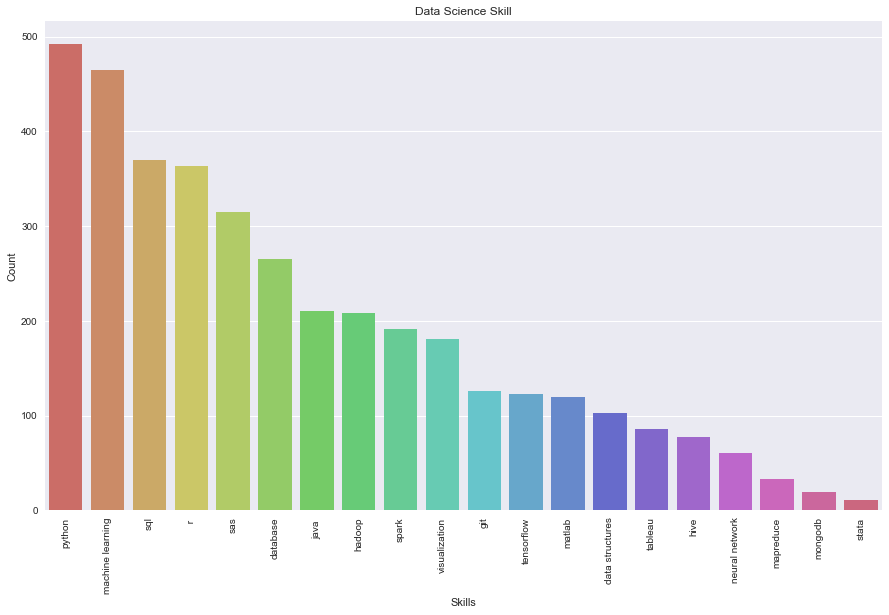

In [20]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,9)})
g = sns.barplot(skill_series.index, skill_series.values, palette = 'hls')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title('Data Science Skill')
g.set(xlabel = 'Skills', ylabel = 'Count')

In [21]:
#delete everything inside parentheses and brackets and then only keep characters!
job_ads['state'] = [re.sub('[^a-zA-Z]+', '', re.sub("[\(\[].*?[\)\]]", "", loc))[-2:] for loc in job_ads['job location']]
job_ads

job title  \
0                                       Data Scientist   
1    Data Scientist Department: Quality, Environmen...   
2                                       Data Scientist   
3                 Data Scientist - Predictive Modeling   
4                                       Data Scientist   
5                                     Data Scientist I   
6                                       Data Scientist   
7                      Data Analyst - Machine Learning   
8                           Data Scientist Entry Level   
9                                       Data Scientist   
10                       Data Analyst / Data Scientist   
11                         Data Scientist (NLP Expert)   
12                                     Data Scientists   
13   Data Scientist Department: Quality, Environmen...   
14                                      Data Scientist   
15                       Data Analyst / Data Scientist   
16                                      Data Scientist   
17                               Junior Data Scientist   
18                                      Data Scientist   
19                                      Data Scientist   
20                                      Data Scientist   
21                           Senior Research Scientist   
22                         Data Scientist (NLP Expert)   
23   Data Scientist Department: Quality, Environmen...   
24                         Data Scientist (NLP Expert)   
25                                      Data Scientist   
26                         Data Scientist - All Levels   
27          Data Scientist (Full Time) - United States   
28                                      Data Scientist   
29                                      Data Scientist   
..                                                 ...   
970  Data Scientist/Bioinformatics Programmer/Data ...   
971                                     Data Scientist   
972  Data Scientist IV (Intelligent Systems / Machi...   
973      Multi-Asset Quantitative Analyst (Structurer)   
974                Data Scientist / Software Developer   
975                Machine Learning Research Scientist   
976                   Data Scientist/Software Engineer   
977                        Data Scientist (NLP Expert)   
978                                    Data Scientists   
979  Data Scientist Department: Quality, Environmen...   
980                 Statistical Programmer (Associate)   
981         Data Scientist, Marketing Data & Analytics   
982                               Quantitative Analyst   
983                                     Data Scientist   
984                                     Data Scientist   
985                        Manager/Director, Analytics   
986     Full Time Engineering and Data Analysis Intern   
987                                Data Science Intern   
988      Deep Learning Engineer (Full-time/Internship)   
989                                     Data Scientist   
990                                     Data Scientist   
991                                    Data Scientists   
992                                     Data Scientist   
993                                  Sr Data Scientist   
994                 Data Scientist-Visualization/UI/UX   
995       Talent Analytics Consultant - Data Scientist   
996                          Data Analytics Consultant   
997  Research and Analytics - Senior Research Analy...   
998                            Data Scientist - iCloud   
999              Data/Experimentation Scientist - Maps   

                                     company  \
0                 DoubleDown Interactive LLC   
1                                  Novozymes   
2    National Geospatial-Intelligence Agency   
3                                    Carvana   
4                  Penn Interactive Ventures   
5        Children's Hospital of Philadelphia   
6                                   Oath Inc   
7                            JP Morgan Chase   
8               

In [22]:
grouped_data = job_ads.groupby('state')
state_series = grouped_data.count().sort_values(by = 'job title', ascending = False)[:10]['job title']

[Text(0,0.5,u'Count'), Text(0.5,0,u'States')]

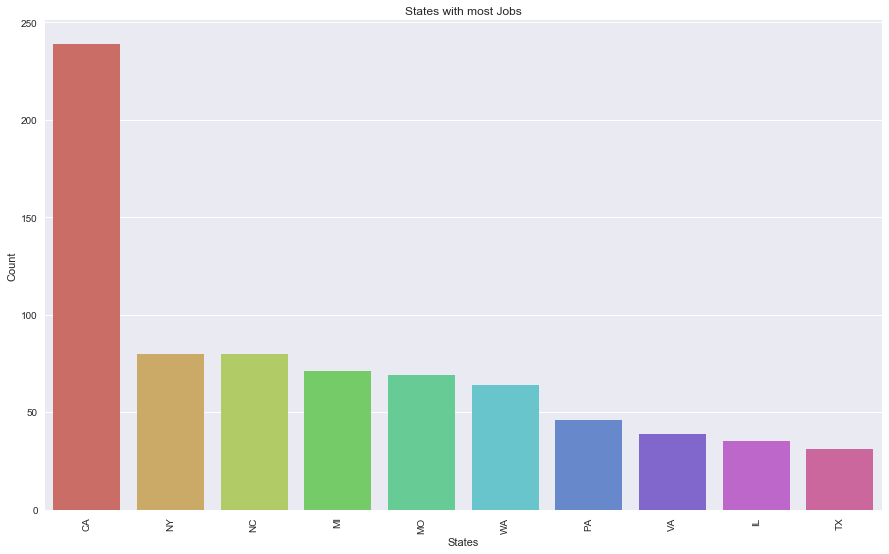

In [23]:
sns.set(rc={'figure.figsize':(15,9)})
g = sns.barplot(state_series.index, state_series.values, palette = 'hls')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title('States with most Jobs')
g.set(xlabel = 'States', ylabel = 'Count')

[Text(0,0.5,u'Count'), Text(0.5,0,u'Companies')]

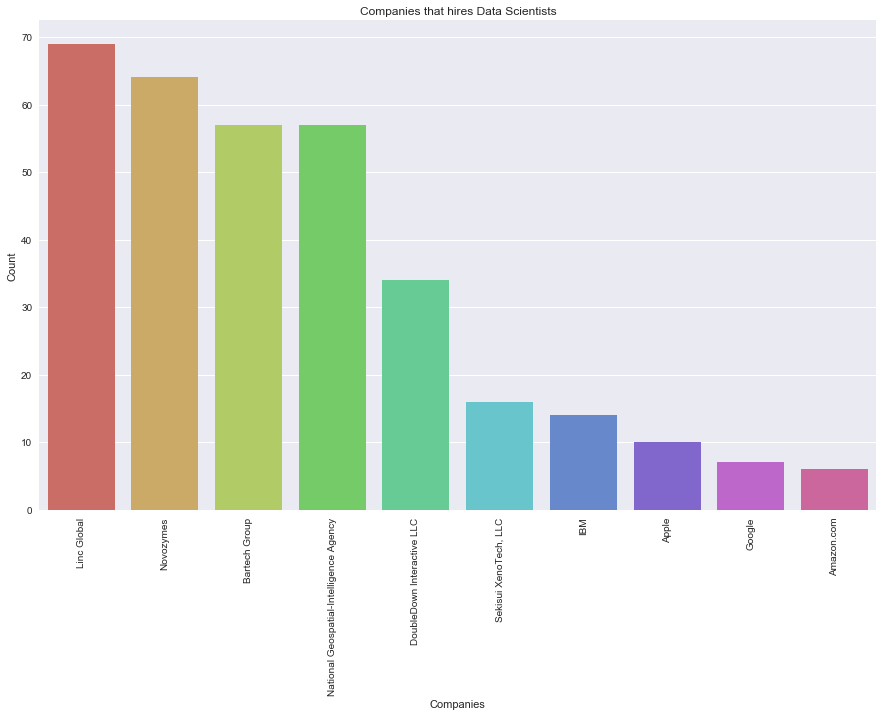

In [24]:
comp_series = job_ads['company'].value_counts()[:10]
comp_series.sort_values(ascending=False)
sns.set(rc={'figure.figsize':(15,9)})
g = sns.barplot(comp_series.index, comp_series.values, palette = 'hls')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title('Companies that hires Data Scientists')
g.set(xlabel = 'Companies', ylabel = 'Count')

In [25]:
CA_df = job_ads[job_ads['state'] == 'CA']
skill_series_CA = CA_df[['machine learning', 'python', 'neural network', 'tensorflow', ' r ', 'sas',
                    'matlab', 'stata', 'visualization', 'tableau', 'data structures', 'java ', 'database', 'sql', 'spark',
                    'mongodb', 'hive', 'git', 'hadoop', 'mapreduce']].sum(axis = 0).sort_values(ascending=False)

[Text(0,0.5,u'Count'), Text(0.5,0,u'Companies')]

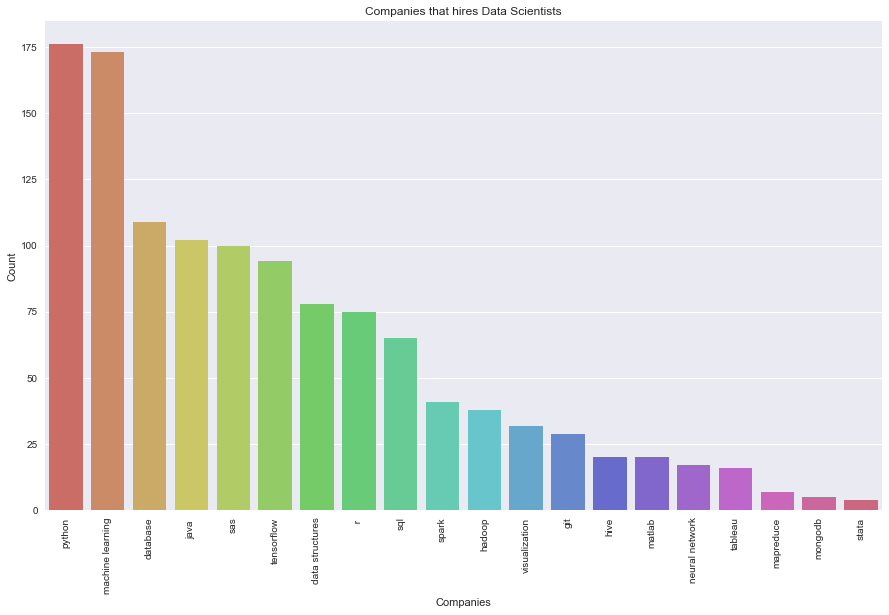

In [26]:
sns.set(rc={'figure.figsize':(15,9)})
g = sns.barplot(skill_series_CA.index, skill_series_CA.values, palette = 'hls')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title('Companies that hires Data Scientists')
g.set(xlabel = 'Companies', ylabel = 'Count')